In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
filename = '../data/raw/bundesliga-team-performance-stats-19-24.xlsx'




In [2]:
def query_db(query):
    conn = sqlite3.connect('../data/bundesliga3.db')
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

In [21]:
squad_map = pd.read_csv('../data/processed/squads_map_performance.csv')
squad_map.head()

df_standings = query_db("SELECT * FROM standings")

df_playerStats = query_db("SELECT * FROM playerStats")

df_transfers = query_db('''SELECT * FROM transfers''')

In [13]:
df_2023_transfers = df_transfers[df_transfers['season_id'] == 2023]
df_2023_transfers.head()

,Unnamed: 0,transfer_id,transfer_date,transfer_type,season,season_id,player_id,player_name,player_age_at_transfer,transfer_fee_euro,...,to_club_name,to_competition_id,to_competition_name,date_of_birth_datetime,citizenship,position.main,position.other,height_cm,foot,updated_at
2226,2226,4446014,01/07/2023,paid transfer,23/24,2023,344381,Christopher Nkunku,25.0,60000000.0,...,Chelsea,GB1,Premier League,14/11/1997,['France' 'DR Congo'],Attacking Midfield,['Second Striker' 'Left Winger'],177.0,right,2024-02-24T18:47:08.352079
2227,2227,4451491,01/07/2023,paid transfer,23/24,2023,242063,Vaclav Cerny,25.0,8000000.0,...,VfL Wolfsburg,L1,Bundesliga,17/10/1997,['Czech Republic'],Right Winger,['Left Winger'],182.0,left,2024-02-24T08:39:52.565472
2228,2228,4433385,01/07/2023,paid transfer,23/24,2023,232418,Ondrej Duda,28.0,2700000.0,...,Hellas Verona,IT1,Serie A,05/12/1994,['Slovakia'],Central Midfield,['Attacking Midfield'],180.0,right,2024-02-24T10:27:10.084035
2229,2229,4418720,01/07/2023,None,23/24,2023,656250,Marcel Lubik,19.0,NaN,...,FC Augsburg,L1,Bundesliga,19/05/2004,['Poland' 'Germany'],Goalkeeper,None,190.0,left,2024-02-26T17:27:32.832987
2230,2230,4419288,01/07/2023,None,23/24,2023,147573,Sebastian Andersson,31.0,NaN,...,Without Club,None,None,15/07/1991,['Sweden'],Centre-Forward,None,190.0,right,2024-02-24T12:36:53.075987


In [14]:
df_playerStats.columns

Index(['Rk', 'season_id_x', 'competition_id', 'Player', 'Nation', 'Pos',
       'Squad', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'PrgP', 'xG_90',
       'xAG_90', 'xG_xAG', 'Gls', 'Sh', 'Cmp', 'Touches', 'PrP_Cmp_100',
       'Sh_Tch_100', 'season', 'club_name', 'club_id', 'League_Position',
       'season_id_y'],
      dtype='object')

In [15]:
df = df_playerStats
club_totals = df.groupby('club_id')[['xG_90', 'xAG_90']].sum().reset_index()
club_totals.rename(columns={'xG_90': 'team_xG', 'xAG_90': 'team_xAG'}, inplace=True)

# Step 2: Merge the club totals back to the original dataframe to associate each player with their team's totals
df = df.merge(club_totals, on='club_id', how='left')

# Step 3: Calculate the percentage contribution of each player's 'xG' and 'xAG' to their team's totals
df['xG_pct_of_team'] = (df['xG_90'] / df['team_xG']) * 100
df['xAG_pct_of_team'] = (df['xAG_90'] / df['team_xAG']) * 100


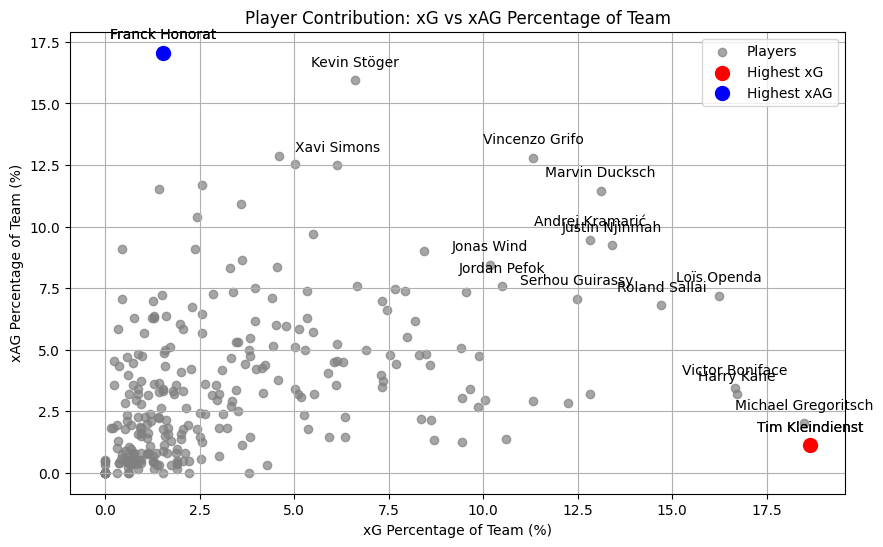

In [16]:
# Step 1: Filter out players with 'Min' >= 1000
df = df[df['Min'] >= 1000]

# Step 2: Find the player with the highest xG percentage and highest xAG percentage
max_xg_player = df.loc[df['xG_pct_of_team'].idxmax()]
max_xag_player = df.loc[df['xAG_pct_of_team'].idxmax()]

# Step 3: Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['xG_pct_of_team'], df['xAG_pct_of_team'], color='grey', alpha=0.7, label='Players')

# Highlight the player with the highest xG
plt.scatter(max_xg_player['xG_pct_of_team'], max_xg_player['xAG_pct_of_team'], color='red', s=100, label='Highest xG')
plt.annotate(max_xg_player['Player'], 
             (max_xg_player['xG_pct_of_team'], max_xg_player['xAG_pct_of_team']),
             textcoords="offset points", xytext=(0,10), ha='center')

# Highlight the player with the highest xAG
plt.scatter(max_xag_player['xG_pct_of_team'], max_xag_player['xAG_pct_of_team'], color='blue', s=100, label='Highest xAG')
plt.annotate(max_xag_player['Player'], 
             (max_xag_player['xG_pct_of_team'], max_xag_player['xAG_pct_of_team']),
             textcoords="offset points", xytext=(0,10), ha='center')

# Step 4: Label players where xG_pct_of_team + xAG_pct_of_team > 18
high_contributors = df[df['xG_pct_of_team'] + df['xAG_pct_of_team'] > 18]

# Annotate those players
for i, row in high_contributors.iterrows():
    plt.annotate(row['Player'], 
                 (row['xG_pct_of_team'], row['xAG_pct_of_team']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Step 5: Add labels and title
plt.xlabel('xG Percentage of Team (%)')
plt.ylabel('xAG Percentage of Team (%)')
plt.title('Player Contribution: xG vs xAG Percentage of Team')
plt.legend()
plt.grid(True)
plt.show()



In [23]:
df.columns
df_player_transfers = pd.merge(df, df_transfers, left_on=['Player','season_id_x'], right_on=['player_name','season_id'], how='outer')
df_player_transfers.columns

Index(['Rk', 'season_id_x', 'competition_id', 'Player', 'Nation', 'Pos',
       'Squad', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'PrgP', 'xG_90',
       'xAG_90', 'xG_xAG', 'Gls', 'Sh', 'Cmp', 'Touches', 'PrP_Cmp_100',
       'Sh_Tch_100', 'season_x', 'club_name', 'club_id', 'League_Position',
       'season_id_y', 'team_xG', 'team_xAG', 'xG_pct_of_team',
       'xAG_pct_of_team', 'transfer_label', 'Unnamed: 0', 'transfer_id',
       'transfer_date', 'transfer_type', 'season_y', 'season_id', 'player_id',
       'player_name', 'player_age_at_transfer', 'transfer_fee_euro',
       'transfer_fee_million', 'market_value_euro', 'market_value_million',
       'from_club_id', 'from_club_name', 'from_competition_id',
       'from_competition_name', 'to_club_id', 'to_club_name',
       'to_competition_id', 'to_competition_name', 'date_of_birth_datetime',
       'citizenship', 'position.main', 'position.other', 'height_cm', 'foot',
       'updated_at'],
      dtype='object')

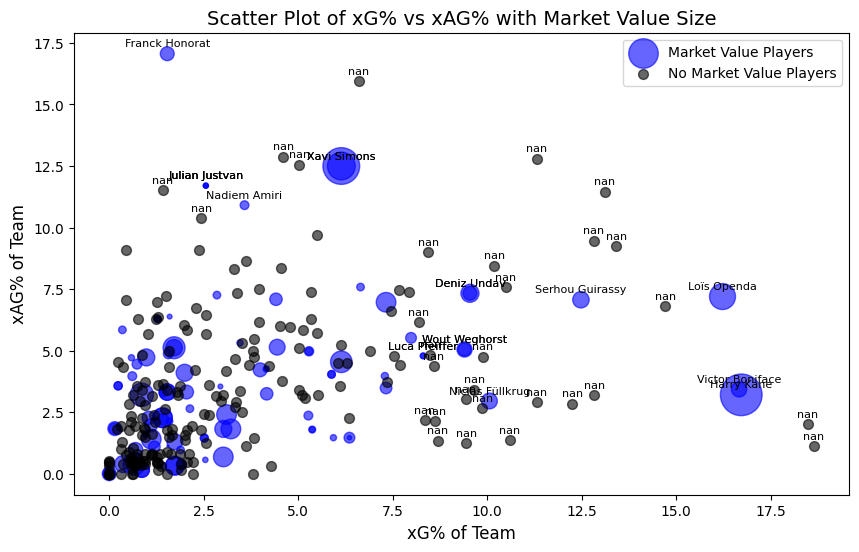

In [29]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Players with market value
mask_with_value = df_player_transfers['market_value_million'].notna()
plt.scatter(
    df_player_transfers.loc[mask_with_value, 'xG_pct_of_team'], 
    df_player_transfers.loc[mask_with_value, 'xAG_pct_of_team'], 
    s=df_player_transfers.loc[mask_with_value, 'market_value_million'] * 10,  # Adjust marker size scale
    alpha=0.6, 
    c='blue', 
    label='Market Value Players'
)

# Players without market value
mask_without_value = df_player_transfers['market_value_million'].isna()
plt.scatter(
    df_player_transfers.loc[mask_without_value, 'xG_pct_of_team'], 
    df_player_transfers.loc[mask_without_value, 'xAG_pct_of_team'], 
    s=50,  # Fixed size for players without market value
    color='black', 
    alpha=0.6, 
    label='No Market Value Players'
)

# Adding labels and title
plt.title('Scatter Plot of xG% vs xAG% with Market Value Size', fontsize=14)
plt.xlabel('xG% of Team', fontsize=12)
plt.ylabel('xAG% of Team', fontsize=12)

# Add player name labels for those with xAG > 10 or xG > 8
for i, row in df_player_transfers.iterrows():
    if row['xAG_pct_of_team'] > 10 or row['xG_pct_of_team'] > 8:
        plt.annotate(
            row['player_name'], 
            (row['xG_pct_of_team'], row['xAG_pct_of_team']),
            textcoords="offset points", 
            xytext=(0, 5),  # Offset label slightly above the point
            ha='center',
            fontsize=8
        )

# Show legend
plt.legend()

# Show plot
plt.show()


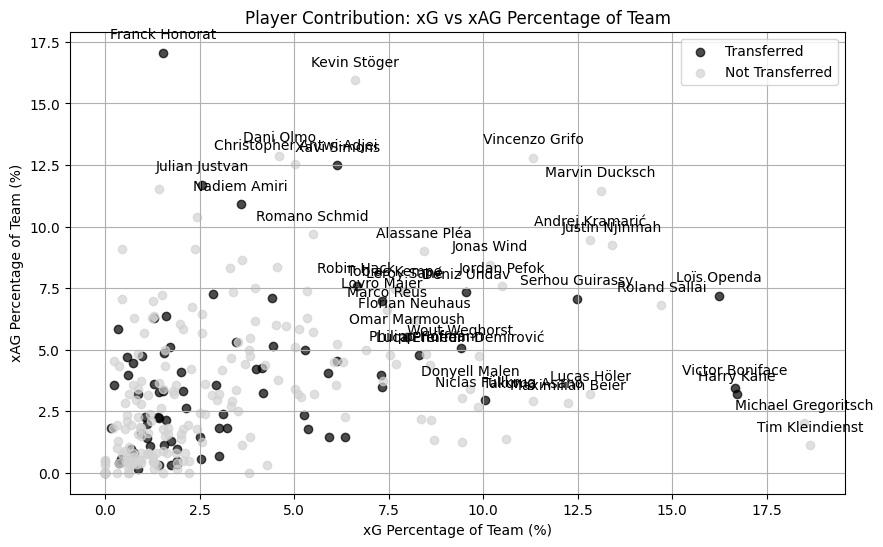

In [19]:


df['transfer_label'] = df['Player'].apply(lambda x: 'x' if x in df_2023_transfers['player_name'].values else 'o')
df = df[df['Min'] >= 1000]

# Step 2: Create the scatter plot with transfer labels
plt.figure(figsize=(10, 6))

# Plot the points and use different markers based on transfer status
# Plot transferred players with dark grey 'o' marker and light grey 'o' for others
for label in ['x', 'o']:
    subset = df[df['transfer_label'] == label]
    color = 'black' if label == 'x' else 'lightgrey'
    plt.scatter(subset['xG_pct_of_team'], subset['xAG_pct_of_team'], 
                marker='o', color=color, 
                alpha=0.7, label=f'{"Transferred" if label == "x" else "Not Transferred"}')

# Step 3: Filter and label players where xG_pct_of_team + xAG_pct_of_team > 13
high_contributors = df[df['xG_pct_of_team'] + df['xAG_pct_of_team'] > 13]

# Annotate those players where xG_pct_of_team + xAG_pct_of_team > 13
for i, row in high_contributors.iterrows():
    plt.annotate(row['Player'], 
                 (row['xG_pct_of_team'], row['xAG_pct_of_team']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Step 4: Add labels and title
plt.xlabel('xG Percentage of Team (%)')
plt.ylabel('xAG Percentage of Team (%)')
plt.title('Player Contribution: xG vs xAG Percentage of Team')
plt.legend()
plt.grid(True)
plt.show()

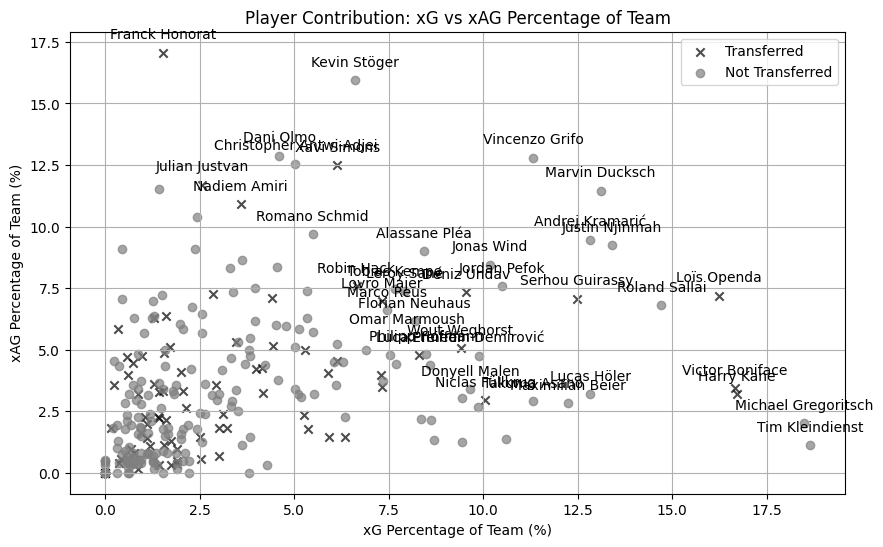

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df contains your player data and df_2023_transfers contains the 2023 transfers

# Step 1: Create a column in df to mark players based on transfers
df['transfer_label'] = df['Player'].apply(lambda x: 'x' if x in df_2023_transfers['player_name'].values else 'o')
df = df[df['Min'] >= 1000]


# Step 2: Create the scatter plot with transfer labels
plt.figure(figsize=(10, 6))

# Plot the points and use different markers based on transfer status
# Plot transferred players with 'x' marker and grey 'o' for others
for label in ['x', 'o']:
    subset = df[df['transfer_label'] == label]
    marker = 'x' if label == 'x' else 'o'
    plt.scatter(subset['xG_pct_of_team'], subset['xAG_pct_of_team'], 
                marker=marker, color='grey' if label == 'o' else 'black', 
                alpha=0.7, label=f'{"Transferred" if label == "x" else "Not Transferred"}')

# Step 3: Filter and label players where xG_pct_of_team + xAG_pct_of_team > 18
high_contributors = df[df['xG_pct_of_team'] + df['xAG_pct_of_team'] > 13]

# Annotate those players where xG_pct_of_team + xAG_pct_of_team > 18
for i, row in high_contributors.iterrows():
    plt.annotate(row['Player'], 
                 (row['xG_pct_of_team'], row['xAG_pct_of_team']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Step 4: Add labels and title
plt.xlabel('xG Percentage of Team (%)')
plt.ylabel('xAG Percentage of Team (%)')
plt.title('Player Contribution: xG vs xAG Percentage of Team')
plt.legend()
plt.grid(True)
plt.show()



In [108]:
# Correct syntax for filtering
player_data = df[df['Player'] == 'Franck Honorat']

# Print the result
player_data

,Rk,season_id_x,competition_id,Player,Nation,Pos,Squad,Age,Born,MP,...,Sh_Tch_100,season,club_name,club_id,League_Position,season_id_y,team_xG,team_xAG,xG_pct_of_team,xAG_pct_of_team
186,187,2023,L1,Franck Honorat,fr FRA,"DF,FW",Gladbach,26.0,1996.0,32,...,1.981599,23/24,Borussia Mönchengladbach,18,14,2023,3.91,2.11,1.534527,17.061611


In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
# Sort the dataframe by the respective metrics
top_100_prp_cmp = df.nlargest(100, 'PrP_Cmp_100')  # Top 100 by 'PrP_Cmp_100'
top_5_prp_cmp = top_100_prp_cmp.nlargest(5, 'PrP_Cmp_100')  # Top 5 by 'PrP_Cmp_100'

top_100_sh_tch = df.nlargest(100, 'Sh_Tch_100')  # Top 100 by 'Sh_Tch_100'
top_20_sh_tch = top_100_sh_tch.nlargest(20, 'Sh_Tch_100')  # Top 5 by 'Sh_Tch_100'

top_100_sh_tch.head()


# # First plot: PrP_Cmp_100 vs Sh_Tch_100, annotate top 5 for PrP_Cmp_100
# plt.figure(figsize=(10, 6))
# plt.scatter(top_100_prp_cmp['PrP_Cmp_100'], top_100_prp_cmp['Sh_Tch_100'], color='grey', label='Top 100 (PrP_Cmp_100)')
# plt.scatter(top_5_prp_cmp['PrP_Cmp_100'], top_5_prp_cmp['Sh_Tch_100'], color='red', label='Top 5 (PrP_Cmp_100)')

# # Annotate the top 5 players for PrP_Cmp_100
# for i, row in top_5_prp_cmp.iterrows():
#     plt.annotate(row['Player'], (row['PrP_Cmp_100'], row['Sh_Tch_100']),
#                  textcoords="offset points", xytext=(0,10), ha='center')

# # Labels and title
# plt.xlabel('PrP_Cmp_100')
# plt.ylabel('Sh_Tch_100')
# plt.title('PrP_Cmp_100 vs Sh_Tch_100 - Annotating Top 5 (PrP_Cmp_100)')
# plt.legend()
# plt.show()

# # Second plot: PrP_Cmp_100 vs Sh_Tch_100, annotate top 5 for Sh_Tch_100
# plt.figure(figsize=(10, 6))
# plt.scatter(top_100_sh_tch['PrP_Cmp_100'], top_100_sh_tch['Sh_Tch_100'], color='grey', label='Top 100 (Sh_Tch_100)')
# plt.scatter(top_5_sh_tch['PrP_Cmp_100'], top_5_sh_tch['Sh_Tch_100'], color='blue', label='Top 5 (Sh_Tch_100)')

# # Annotate the top 5 players for Sh_Tch_100
# for i, row in top_5_sh_tch.iterrows():
#     plt.annotate(row['Player'], (row['PrP_Cmp_100'], row['Sh_Tch_100']),
#                  textcoords="offset points", xytext=(0,10), ha='center')

# # Labels and title
# plt.xlabel('PrP_Cmp_100')
# plt.ylabel('Sh_Tch_100')
# plt.title('PrP_Cmp_100 vs Sh_Tch_100 - Annotating Top 5 (Sh_Tch_100)')
# plt.legend()
# plt.show()


,Rk,season_id_x,competition_id,Player,Nation,Pos,Squad,Age,Born,MP,...,season,club_name,club_id,League_Position,season_id_y,team_xG,team_xAG,xG_pct_of_team,xAG_pct_of_team,transfer_label
218,219,2023,L1,Harry Kane,eng ENG,FW,Bayern Munich,30.0,1993.0,32,...,23/24,Bayern Munich,27,3,2023,5.80,6.24,16.724138,3.205128,x
341,342,2023,L1,Loïs Openda,be BEL,FW,RB Leipzig,23.0,2000.0,34,...,23/24,RB Leipzig,23826,4,2023,4.56,2.64,16.228070,7.196970,x
54,55,2023,L1,Victor Boniface,ng NGA,FW,Leverkusen,22.0,2000.0,23,...,23/24,Bayer 04 Leverkusen,15,1,2023,5.40,6.42,16.666667,3.426791,x
151,152,2023,L1,Michael Gregoritsch,at AUT,FW,Freiburg,29.0,1994.0,32,...,23/24,SC Freiburg,60,10,2023,2.65,2.50,18.490566,2.000000,o
407,408,2023,L1,Patrik Schick,cz CZE,FW,Leverkusen,27.0,1996.0,20,...,23/24,Bayer 04 Leverkusen,15,1,2023,5.40,6.42,9.444444,1.246106,o


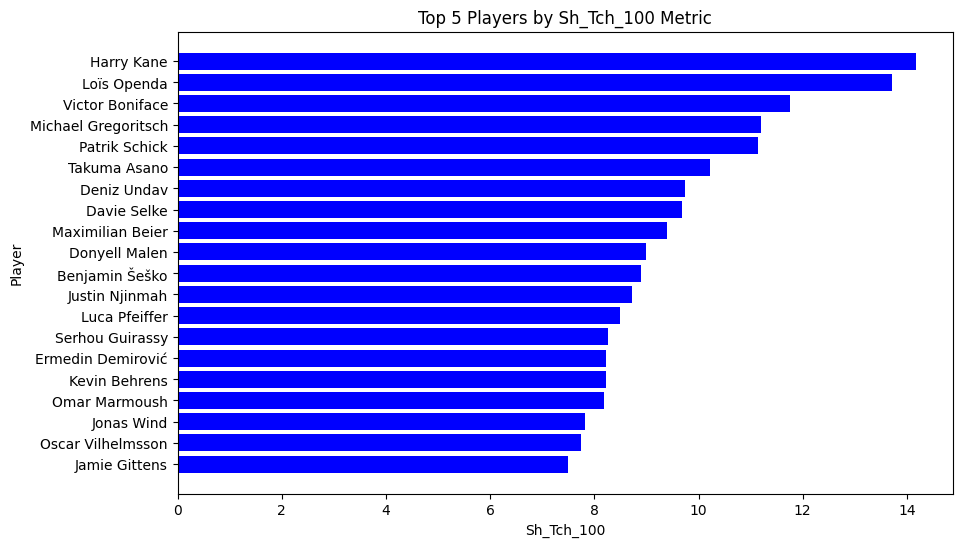

In [136]:
# Plotting the top 5 players by Sh_Tch_100
plt.figure(figsize=(10, 6))
plt.barh(top_20_sh_tch['Player'], top_20_sh_tch['Sh_Tch_100'], color='blue')
plt.xlabel('Sh_Tch_100')
plt.ylabel('Player')
plt.title('Top 5 Players by Sh_Tch_100 Metric')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.show()

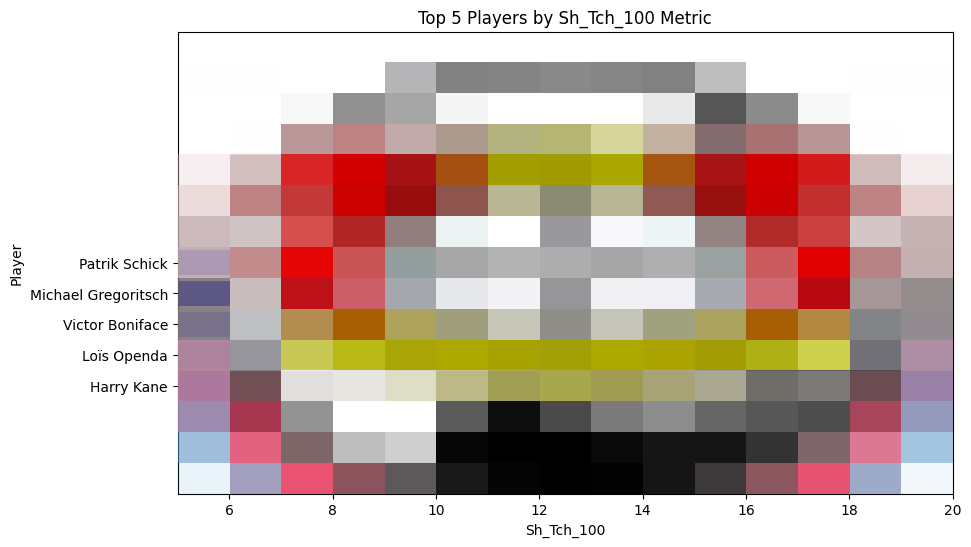

In [145]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

top_20_sh_tch = pd.DataFrame(top_20_sh_tch)

# Select top 5 players by Sh_Tch_100
top_5_sh_tch = top_20_sh_tch.nlargest(5, 'Sh_Tch_100')

# Image folder path
image_folder = '../images/football-logos/logos/Germany - Bundesliga/'

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(top_5_sh_tch['Player'], top_5_sh_tch['Sh_Tch_100'], color='blue')
plt.xlabel('Sh_Tch_100')
plt.ylabel('Player')
plt.title('Top 5 Players by Sh_Tch_100 Metric')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top

# Add images instead of text
for bar, img_name in zip(bars, top_5_sh_tch['club_name']):
    # Construct the full image path
    img_path = image_folder + img_name + '.png'

    # Load the image
    img = Image.open(img_path)

    # Resize the image to fit better (try smaller dimensions)
    img = img.resize((15, 15))  # Resize to 15x15 pixels
    
    # Convert the image to an array
    img_arr = np.array(img)

    # Get the height and width of the bar
    height = bar.get_height()
    width = bar.get_x() + bar.get_width() / 2.0

    # Place the image on the bar with a slight offset
    plt.imshow(img_arr, aspect='auto', 
               extent=(bar.get_x() + 5, bar.get_x() + 5 + 15, bar.get_y() + height/2 - 7.5, bar.get_y() + height/2 + 7.5), 
               zorder=10)

# Show the plot
plt.show()


In [130]:
# First plot: PrP_Cmp_100 vs Sh_Tch_100, annotate top 5 for PrP_Cmp_100
plt.figure(figsize=(10, 6))
plt.scatter(top_100_prp_cmp['PrP_Cmp_100'], top_100_prp_cmp['Sh_Tch_100'], color='grey', label='Top 100 (PrP_Cmp_100)')
plt.scatter(top_5_prp_cmp['PrP_Cmp_100'], top_5_prp_cmp['Sh_Tch_100'], color='red', label='Top 5 (PrP_Cmp_100)')

# Annotate the top 5 players for PrP_Cmp_100
for i, row in top_5_prp_cmp.iterrows():
    plt.annotate(row['Player
    
    '], (row['PrP_Cmp_100'], row['Sh_Tch_100']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Labels and title
plt.xlabel('PrP_Cmp_100')
plt.ylabel('Sh_Tch_100')
plt.title('PrP_Cmp_100 vs Sh_Tch_100 - Annotating Top 5 (PrP_Cmp_100)')
plt.legend()
plt.show()

# Second plot: PrP_Cmp_100 vs Sh_Tch_100, annotate top 5 for Sh_Tch_100
plt.figure(figsize=(10, 6))
plt.scatter(top_100_sh_tch['PrP_Cmp_100'], top_100_sh_tch['Sh_Tch_100'], color='grey', label='Top 100 (Sh_Tch_100)')
plt.scatter(top_5_sh_tch['PrP_Cmp_100'], top_5_sh_tch['Sh_Tch_100'], color='blue', label='Top 5 (Sh_Tch_100)')

# Annotate the top 5 players for Sh_Tch_100
for i, row in top_5_sh_tch.iterrows():
    plt.annotate(row['Player'], (row['PrP_Cmp_100'], row['Sh_Tch_100']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Labels and title
plt.xlabel('PrP_Cmp_100')
plt.ylabel('Sh_Tch_100')
plt.title('PrP_Cmp_100 vs Sh_Tch_100 - Annotating Top 5 (Sh_Tch_100)')
plt.legend()
plt.show()

SyntaxError: unterminated string literal (detected at line 8) (2321787307.py, line 8)

In [76]:
# Load the Excel file
xls = pd.ExcelFile(filename)
sheet_names = xls.sheet_names

# Initialize an empty list to hold DataFrames
df_stats = []

# Loop through each sheet and read the DataFrame
for sheet in sheet_names:
    print(sheet)  # Print the name of the current sheet
    df = pd.read_excel(filename, sheet_name=sheet)
    df['season'] = sheet  # Add a new column with the season
    df['season'] = df['season'].str.replace('_', '/')  # Remove 'Stats' from the season name
    df_stats.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
df_stats = pd.concat(df_stats, ignore_index=True)

df_stats = df_stats.loc[:, ~df_stats.columns.duplicated()]
df_stats = pd.merge(df_stats, squad_map, how='left', left_on='Squad', right_on='Squad')


df_stats = pd.merge(df_stats, df_standings[['League_Position', 'club_id', 'season','season_id']], how='left', left_on=['club_id', 'season'], right_on=['club_id', 'season'])
df_stats

19_20
20_21
21_22
22_23
23_24


,Squad,players,Age,Poss,MP,Starts,Min,90s,Gls,Ast,...,CPA,Mis,Dis,Rec,PrgR,season,club_name,club_id,League_Position,season_id
0,Augsburg,28.0,26.2,38.6,34.0,374.0,3060.0,34.0,45.0,29.0,...,104.0,512.0,304.0,8347.0,808.0,19/20,FC Augsburg,167.0,15,2019.0
1,Bayern Munich,29.0,26.7,65.1,34.0,374.0,3060.0,34.0,97.0,75.0,...,266.0,515.0,309.0,20486.0,2285.0,19/20,Bayern Munich,27.0,1,2019.0
2,Dortmund,27.0,25.8,60.4,34.0,374.0,3060.0,34.0,84.0,74.0,...,199.0,494.0,351.0,20513.0,1729.0,19/20,Borussia Dortmund,16.0,2,2019.0
3,Düsseldorf,28.0,27.1,45.6,34.0,374.0,3060.0,34.0,36.0,26.0,...,97.0,476.0,272.0,11271.0,1256.0,19/20,Fortuna Düsseldorf,38.0,17,2019.0
4,Eint Frankfurt,27.0,27.0,50.9,34.0,374.0,3060.0,34.0,57.0,45.0,...,147.0,523.0,301.0,12165.0,1380.0,19/20,Eintracht Frankfurt,24.0,9,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,RB Leipzig,26.0,25.6,55.3,34.0,374.0,3060.0,34.0,74.0,53.0,...,177.0,488.0,332.0,16170.0,1530.0,23/24,RB Leipzig,23826.0,4,2023.0
88,Stuttgart,27.0,25.0,59.9,34.0,374.0,3060.0,34.0,78.0,60.0,...,191.0,561.0,329.0,18993.0,1602.0,23/24,VfB Stuttgart,79.0,2,2023.0
89,Union Berlin,30.0,28.1,42.9,34.0,374.0,3060.0,34.0,33.0,23.0,...,112.0,549.0,293.0,10894.0,1132.0,23/24,1. FC Union Berlin,89.0,15,2023.0
90,Werder Bremen,30.0,27.0,46.8,34.0,374.0,3060.0,34.0,45.0,33.0,...,108.0,541.0,263.0,12715.0,1163.0,23/24,Werder Bremen,86.0,9,2023.0


In [77]:
# Get the list of column names
column_names = df_stats.columns.tolist()

# Display the column names
print("Column names in the DataFrame:")
for i, col in enumerate(column_names):
    print(f"{i + 1}: {col}")


df_stats = df_stats.drop(columns=['Squad', 'Squad.1','Squad.2','Squad.3','Squad.4','Squad.5','Squad.6','club_name','season'])

Column names in the DataFrame:
1: Squad
2: players
3: Age
4: Poss
5: MP
6: Starts
7: Min
8: 90s
9: Gls
10: Ast
11: G+A
12: G-PK
13: PK
14: PKatt
15: CrdY
16: CrdR
17: xG
18: npxG
19: xAG
20: npxG_xAG
21: PrgC
22: PrgP
23: Gls_90
24: Ast_90
25: G_A_90
26: G_PK_90
27: G_A_PK_90
28: xG_90
29: xAG_90
30: xG_xAG_90
31: npxG_90
32: npxG_xAG_90
33: Squad.1
34: goalkeepers
35: MP.1
36: Starts.1
37: Min.1
38: 90s.1
39: GA_gk
40: GA90_gk
41: SoTA_gk
42: Saves_gk
43: Save_perc_gk
44: W_gk
45: D_gk
46: L_gk
47: CS_gk
48: CS_perc_gk
49: Pkatt_gk
50: PKA_gk
51: PKsv_gk
52: PKm_gk
53: Save_perc_gk.1
54: Squad.2
55: players.1
56: 90s.2
57: Gls.1
58: Shots
59: SoT
60: SoT_perc
61: Sh_90
62: SoT_90
63: G_Sh
64: G_SoT
65: Dist
66: FK
67: PK.1
68: PKatt.1
69: xG.1
70: npxG.1
71: npxG_Sh
72: G_xG
73: np_G_xG
74: Squad.3
75: players.2
76: 90s.3
77: Cmp_pass
78: Att_pass
79: Cmp_perc_pass
80: TotDist_pass
81: PrgDist_pass
82: Cmp_short
83: Att_short
84: Cmp_perc_short
85: Cmp_med
86: Att_med
87: Cmp_perc_med

In [78]:
#Correlation analysis of team performance features and league position

corr_matrix = df_stats.corr()

league_position_corr = corr_matrix['League_Position'].sort_values(ascending=False)
sorted_corr = league_position_corr.sort_values()
# Display the results in a loop
print("Features influencing 'League Position' (sorted by correlation):")
for feature, correlation in sorted_corr.items():
    print(f"Feature: {feature}, Correlation: {correlation:.4f}")


corr_df = sorted_corr.reset_index()
corr_df.columns = ['feature', 'correlation']
corr_df.to_excel('../data/correlation/correlation_team_performance.xlsx', index=False)

Features influencing 'League Position' (sorted by correlation):
Feature: W_gk, Correlation: -0.9397
Feature: Gls, Correlation: -0.8694
Feature: Gls.1, Correlation: -0.8694
Feature: Gls_90, Correlation: -0.8692
Feature: G-PK, Correlation: -0.8668
Feature: G_PK_90, Correlation: -0.8661
Feature: G_A_90, Correlation: -0.8656
Feature: G+A, Correlation: -0.8655
Feature: G_A_PK_90, Correlation: -0.8625
Feature: GCA, Correlation: -0.8587
Feature: GCA90, Correlation: -0.8587
Feature: Ast_90, Correlation: -0.8492
Feature: Ast.1, Correlation: -0.8492
Feature: Ast, Correlation: -0.8492
Feature: xG, Correlation: -0.8344
Feature: xG.1, Correlation: -0.8344
Feature: xG_90, Correlation: -0.8344
Feature: xG_xAG_90, Correlation: -0.8279
Feature: PassLive_GCA, Correlation: -0.8247
Feature: npxG_90, Correlation: -0.8228
Feature: npxG, Correlation: -0.8227
Feature: npxG.1, Correlation: -0.8227
Feature: npxG_xAG, Correlation: -0.8194
Feature: G_Sh, Correlation: -0.8190
Feature: xAG, Correlation: -0.8105
Fea

In [86]:
#Filter df by features with correlation >0.7

# Get the features with correlation less than -0.7
features = league_position_corr[league_position_corr < -0.7].index.tolist()

# Include the target variable 'League Position' in the features list
features.append('League_Position')

# Create a new DataFrame with only the selected features and the target variable
features_df = df_stats[features]

# # Display the resulting DataFrame
# print("Filtered DataFrame with selected features and target variable:")
# print(features_df)

In [84]:
cols_of_interest = ['G_A_90','xG_xAG_90','SoT_90','Att_pass','poss_perc','Touches','Carries']
#convert all of df_stats to numeric
df_stats = df_stats.apply(pd.to_numeric, errors='coerce')


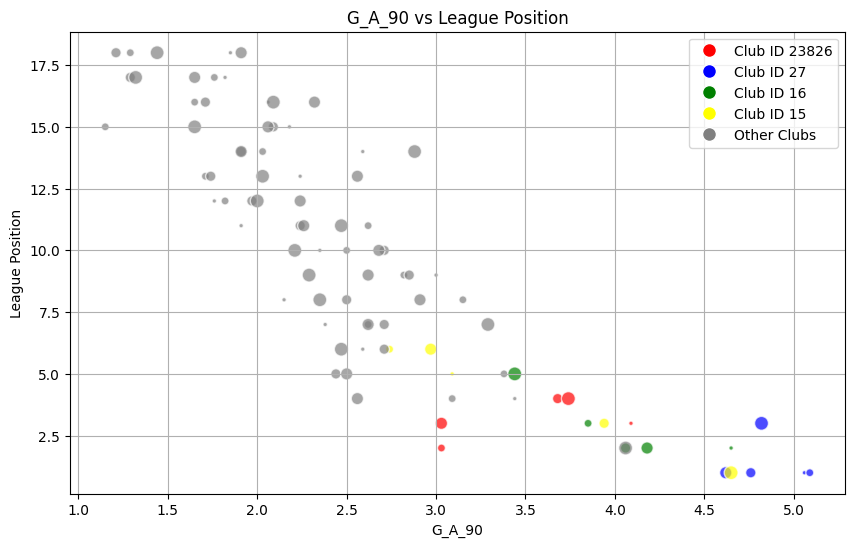

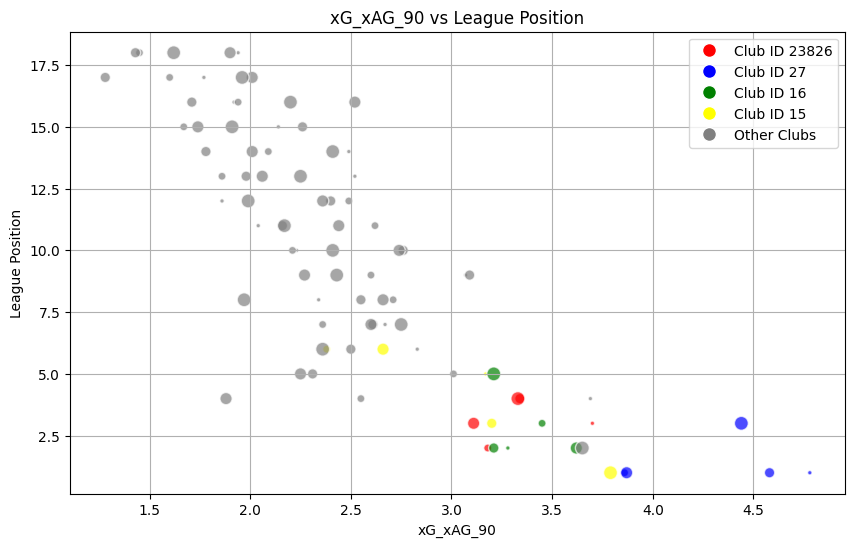

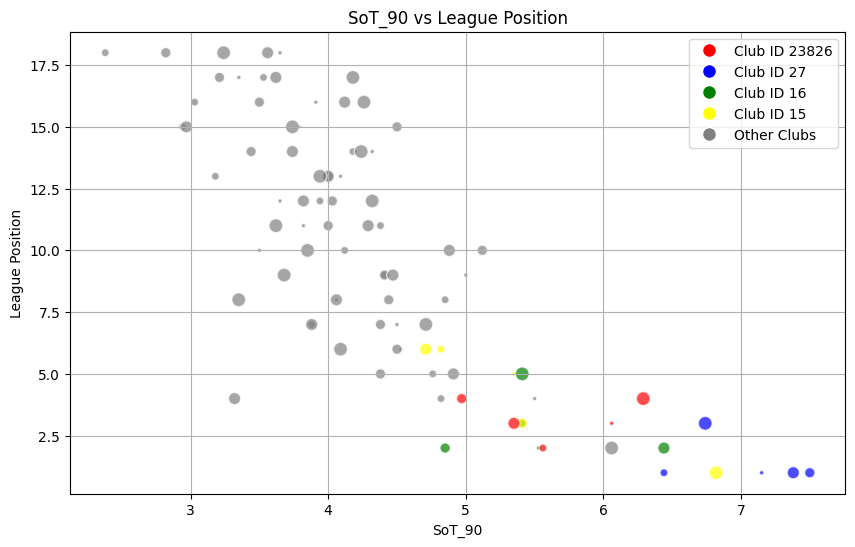

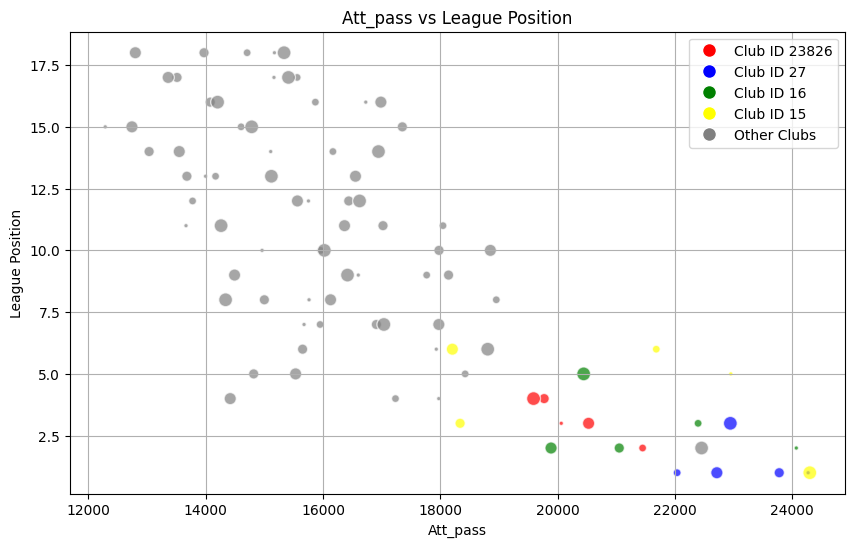

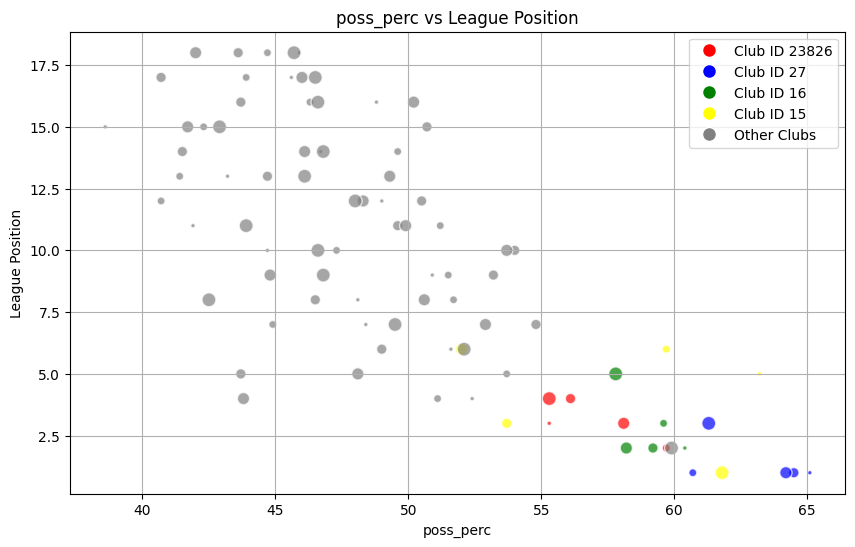

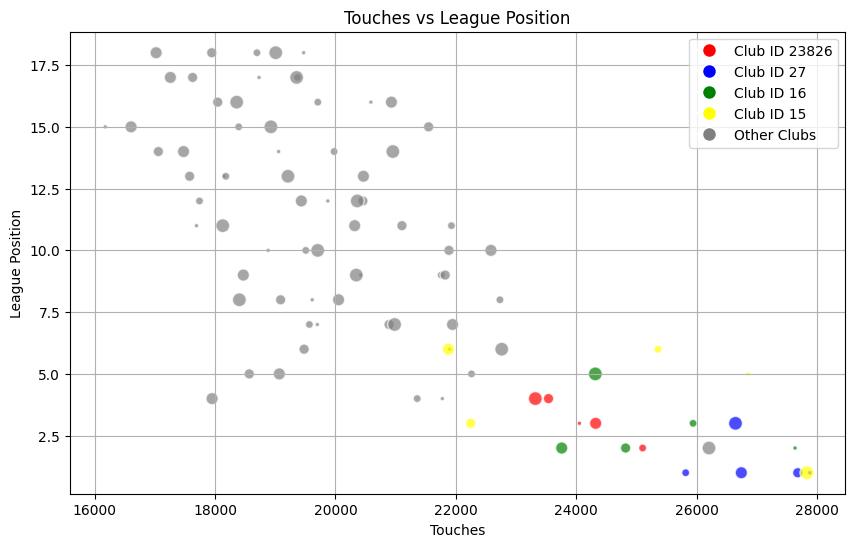

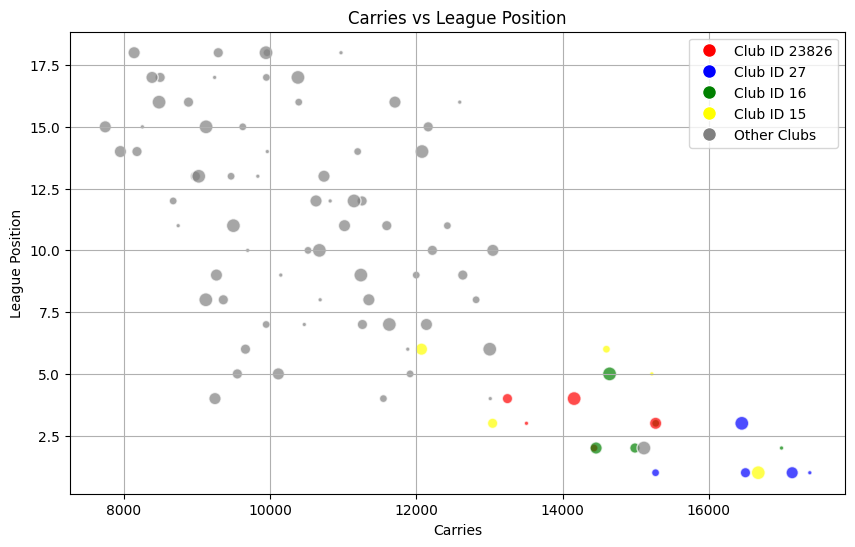

In [85]:

# Define columns of interest
cols_of_interest = ['G_A_90', 'xG_xAG_90', 'SoT_90', 'Att_pass', 'poss_perc', 'Touches', 'Carries']

# Convert all of df_stats to numeric
df_stats = df_stats.apply(pd.to_numeric, errors='coerce')
df_stats['club_id'] = df_stats['club_id'].astype('category')

# Define colors for specific club_ids
club_color_map = {
    23826: 'red',
    27: 'blue',
    16: 'green',
    15: 'yellow'
}

# Create a new column in df_stats to hold the colors based on club_id
df_stats['color'] = df_stats['club_id'].map(club_color_map).fillna('grey')

# Normalize the marker sizes based on season_id
# Here, we assume a reasonable range for sizes; you can adjust the factor for better visibility
min_size = 10
max_size = 100
size_factor = (df_stats['season_id'] - df_stats['season_id'].min()) / (df_stats['season_id'].max() - df_stats['season_id'].min())
df_stats['marker_size'] = min_size + (max_size - min_size) * size_factor

# For each column of interest, plot a scatter plot against 'League_Position'
for col in cols_of_interest:
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Create the scatter plot using the color column and the marker size
    scatter = plt.scatter(df_stats[col], df_stats['League_Position'], 
                          c=df_stats['color'], s=df_stats['marker_size'], alpha=0.7, edgecolor='w')

    # Add a color bar - only for specific club IDs
    # Create a custom legend for specific colors
    handles = [plt.Line2D([0], [0], marker='o', color='w', label='Club ID 23826', markerfacecolor='red', markersize=10),
               plt.Line2D([0], [0], marker='o', color='w', label='Club ID 27', markerfacecolor='blue', markersize=10),
               plt.Line2D([0], [0], marker='o', color='w', label='Club ID 16', markerfacecolor='green', markersize=10),
               plt.Line2D([0], [0], marker='o', color='w', label='Club ID 15', markerfacecolor='yellow', markersize=10),
               plt.Line2D([0], [0], marker='o', color='w', label='Other Clubs', markerfacecolor='grey', markersize=10)]

    plt.legend(handles=handles, loc='upper right')

    # Adding titles and labels
    plt.title(f'{col} vs League Position')
    plt.xlabel(col)
    plt.ylabel('League Position')
    plt.grid(True)

    # Show the plot
    plt.show()


In [82]:
df_stats['season_id']

0     2019.0
1     2019.0
2     2019.0
3     2019.0
4     2019.0
       ...  
87    2023.0
88    2023.0
89    2023.0
90    2023.0
91    2023.0
Name: season_id, Length: 92, dtype: float64